# Smarter Hochwasser Schutz - Challenge Notebook
This notebook can be seen as starting point and exercise for the challenge

---

## How to start
At first you should start creating an Account at the Divabre website at [https://platform.divabre.de/home](https://platform.divabre.de/home).
This will allow you to participate in the challenges and to download the challenge's data files.

To get the data for the flood-challenge search for the 'Challenges' category on the top row of the website. There you will find the challenge for this notebook, called ["Smarter Hochwasser Schutz Challenge"](https://platform.divabre.de/challenges/c8d031ca-469e-4a3a-95fd-96ea7baeb687/overview).

There you will find a short description of the project and the data that is provided (sensor types, units of measurement, etc.). Also, under 'Data Sources', you can find two CSV files necessary for this challenge. One is the training dataset, used for model generation, training and pre-evaluation; and the other one is the official test data set, to finally evaluate your model's performance.

NOTE: You have to be logged in at the Divabre website to download any files from there. If the download fails, try to login and download again. If that still yields no result, feel free to contact us: (yhahn@uni-wuppertal.de; kienitz@uni-wuppertal.de)

In this notebook you will find several cells with little tasks and examples that shall function as help to find your way into the dataset and to get an idea of a simple prediction model.


In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from torch import Tensor
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

In [2]:
# Params
batch_size = 32

epochs = 10

data_dir = "data" # Enter the path of your choice

train_filename = f"{data_dir}/x_train.csv"

### Check for a GPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"GPU: '{device}' available" if device.type == "cuda" else f"No GPU available, pytorch will run on your CPU.")

No GPU available, pytorch will run on your CPU.


In [4]:
raw_data = pd.read_csv(train_filename, sep=";", date_parser="date")
raw_data.date = pd.to_datetime(raw_data.date)
raw_data.index = raw_data.date
raw_data = raw_data.drop(columns=['date'], axis=0)
raw_data.head()

,"Discharge, Stausee Beyenburg","Water Level, Stausee Beyenburg","Water Level, Kluserbrücke","Precipitation, Beyenburg","Water Level, Leimbach","Precipitation, Barmen Wupperverband Hauptverwaltung"
date,,,,,,
2020-03-28 08:00:00,1.950000,23.500000,18.750000,0.0,7.680000,0.0
2020-03-28 08:30:00,1.950000,23.416667,18.723077,0.0,7.180000,0.0
2020-03-28 09:00:00,1.950000,23.683333,18.740000,0.0,6.666667,0.0
2020-03-28 09:30:00,1.950000,23.840000,18.692857,0.0,6.783333,0.0
2020-03-28 10:00:00,1.963333,23.980000,18.720000,0.0,6.700000,0.0


## Exploration of the dataset
As a first step find a meaningful graphical representation to get a first grasp of the data and to detect anomalies or peculiarities that are easily observable.

E.g. create a boxplot of the sensors data given by the 6 different sensor available; Plot the values of each sensor against the time parameter to get an idea how the time series data looks like.

Could you possibly identify a time point in the data, where there was the Wupper-flood incident in 2021?

In [5]:
# Choose a visualization method to show the distribution of the sensor output data like a boxplot diagram

def box_plotter(data: pd.DataFrame):
    """
    Creates a simple boxplot over all columns in the dataframe
    """
    fig, ax = plt.subplots()
    ax.set_title('Sensor readouts - Boxplot')
    ax.boxplot(data, flierprops=dict(marker='.', markerfacecolor='black', markersize=4,
                                     linestyle='none', markeredgecolor='black'))

    ax.set_xticklabels(data.keys(), rotation=45, ha='right')

    plt.show()

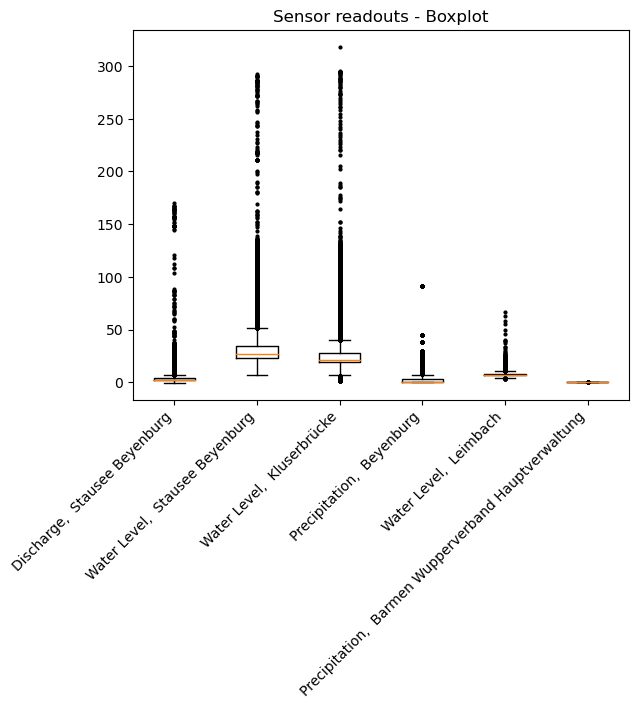

In [6]:
box_plotter(raw_data)

<AxesSubplot:>

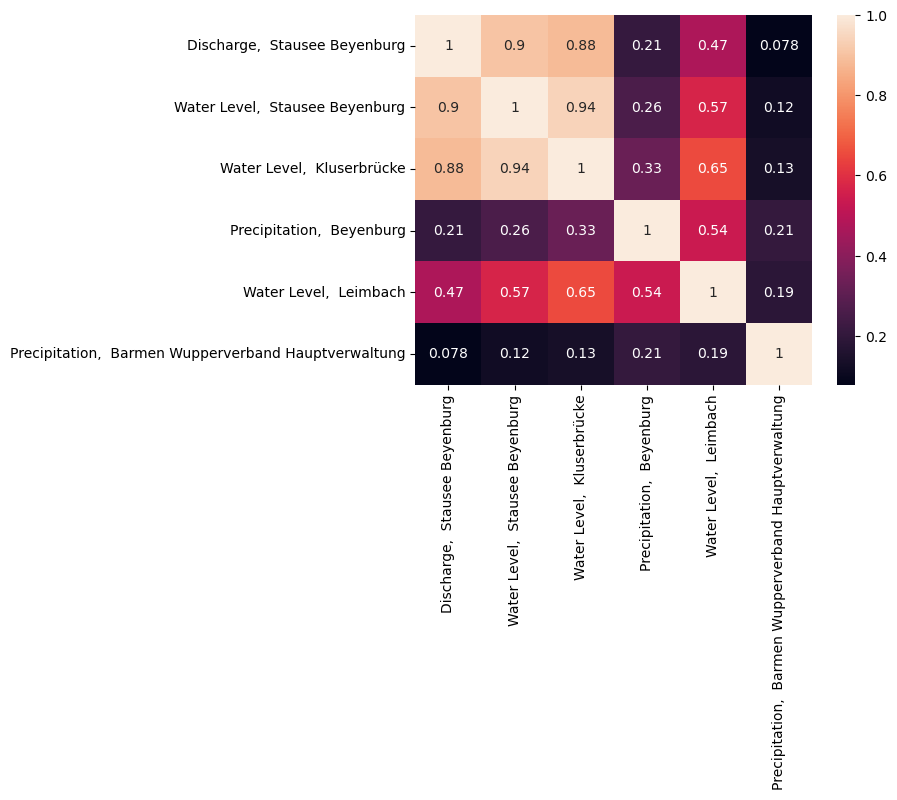

In [7]:
corr = raw_data.corr()
sns.heatmap(corr, annot = True)

## Basic statistical data
Try to get some simple statistical values to describe the sensor data (e.g. mean, St. dev, quantiles).
Explore further: Are there 'impossible' or just extremely unlikely values/entries in your data frame (e.g. negative values, where only positives are allowed or NaN entries)?

In [8]:
raw_data.describe()

,"Discharge, Stausee Beyenburg","Water Level, Stausee Beyenburg","Water Level, Kluserbrücke","Precipitation, Beyenburg","Water Level, Leimbach","Precipitation, Barmen Wupperverband Hauptverwaltung"
count,33153.000000,33153.000000,33153.000000,33153.000000,33153.000000,33153.000000
mean,4.738007,34.798158,28.151466,2.861822,7.780249,0.000755
std,8.486383,23.029031,20.206118,6.254670,2.294230,0.010895
min,-0.496667,7.116667,1.033333,0.000000,3.340000,0.000000
25%,2.158333,23.366667,19.171429,0.000000,6.480000,0.000000
50%,2.590000,26.760000,21.200000,0.000000,7.275000,0.000000
75%,3.968333,34.683333,27.650000,3.000000,8.283333,0.000000
max,169.830000,292.300000,318.214286,91.000000,66.240000,0.423333


In [9]:
# Add a function that checks all columns in a datafram for missing or negative values as those would clearly be erroneous
# information in the dataset

def data_check(dataset: pd.DataFrame):
    """
    A function that checks the dataframe for negative or missing values and prints 
    
    """

    for i in range(dataset.shape[1]):

        data = np.array(dataset.iloc[0:, i])

        print(f'{dataset.keys()[i]}')
        if np.isnan(data).any() == True:

            print('Data contains NaN at indices: ' + str(np.argwhere(np.isnan(data))))

        else:

            print('Data contains no NaN')

        neg_value = []
        neg_value = data[data < 0]

        if len(neg_value) == 0:

            print('Data contains no negative values \n')

        else:

            print('Data contains negative values at indices:' + str(np.argwhere(data < 0)) +'\n')

In [10]:
data_check(raw_data)

Discharge,  Stausee Beyenburg
Data contains no NaN
Data contains negative values at indices:[[1120]]

Water Level,  Stausee Beyenburg
Data contains no NaN
Data contains no negative values 

Water Level,  Kluserbrücke
Data contains no NaN
Data contains no negative values 

Precipitation,  Beyenburg
Data contains no NaN
Data contains no negative values 

Water Level,  Leimbach
Data contains no NaN
Data contains no negative values 

Precipitation,  Barmen Wupperverband Hauptverwaltung
Data contains no NaN
Data contains no negative values 



## Data visualization
In this section try to plot each sensor output over time to get an impression how the signals behave and if you can spot any curiosities like trends or extreme signals visible by the bare eye.

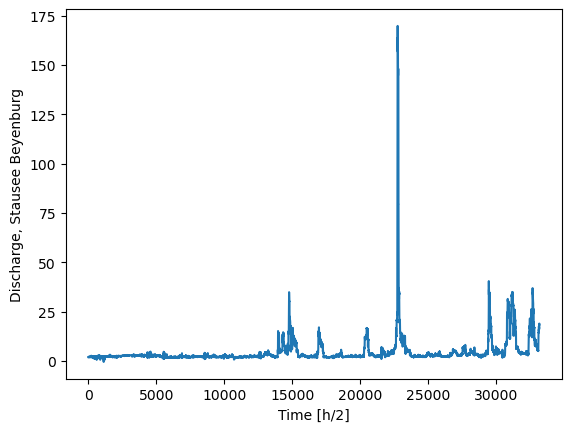

In [11]:
# Plot to exemplary show one sensor signal over time

fig, ax = plt.subplots()

ax.set_title = 'Discharge, Stausee Beyenburg'
ax.plot(np.arange(raw_data.shape[0]), raw_data.iloc[0:, 0])
ax.set_xlabel('Time [h/2]')
ax.set_ylabel('Discharge, Stausee Beyenburg')

plt.show()

In [12]:
# Write a function to plot the output of each sensor on its own against the time parameter.

def single_plot(data: pd.DataFrame, counter: int):
    """
    The function allows to plot the output of a single sensor over time; the counter keyword is an integer calling the
    different columns of the data frame.
    """

    fig, ax = plt.subplots()

    ax.set_title = f'{data.keys()[counter]}'
    ax.plot(np.arange(data.shape[0]), data.iloc[0:, counter])
    ax.set_xlabel('Time [h/2]')
    ax.set_ylabel(f'{data.keys()[counter]}')

    plt.show()

Try to plot all outputs of the sensors simultaneously, sharing the same time axis to compare them

In [13]:
# Write a function to plot all sensor outputs in seperate plot windows simultaneously but with a shared time axis.

def multi_singleplot(data: pd.DataFrame):
    """
    This function creates a single plot for every sensor output over the same time scale; it iterates automatically over all
    columns in the dataset printing the corresponding data with its title.
    """

    fig, ax = plt.subplots(data.shape[1], figsize=(15, 20), gridspec_kw={'hspace': 1})

    for i in range(data.shape[1]):
        ax[i].set_title(f'{data.keys()[i]}')
        ax[i].plot(np.arange(data.shape[0]), data.iloc[0:, i])
        ax[i].set_xlabel('Time [h/2]')
        ax[i].set_ylabel(f'{data.keys()[i]}')

    plt.show()

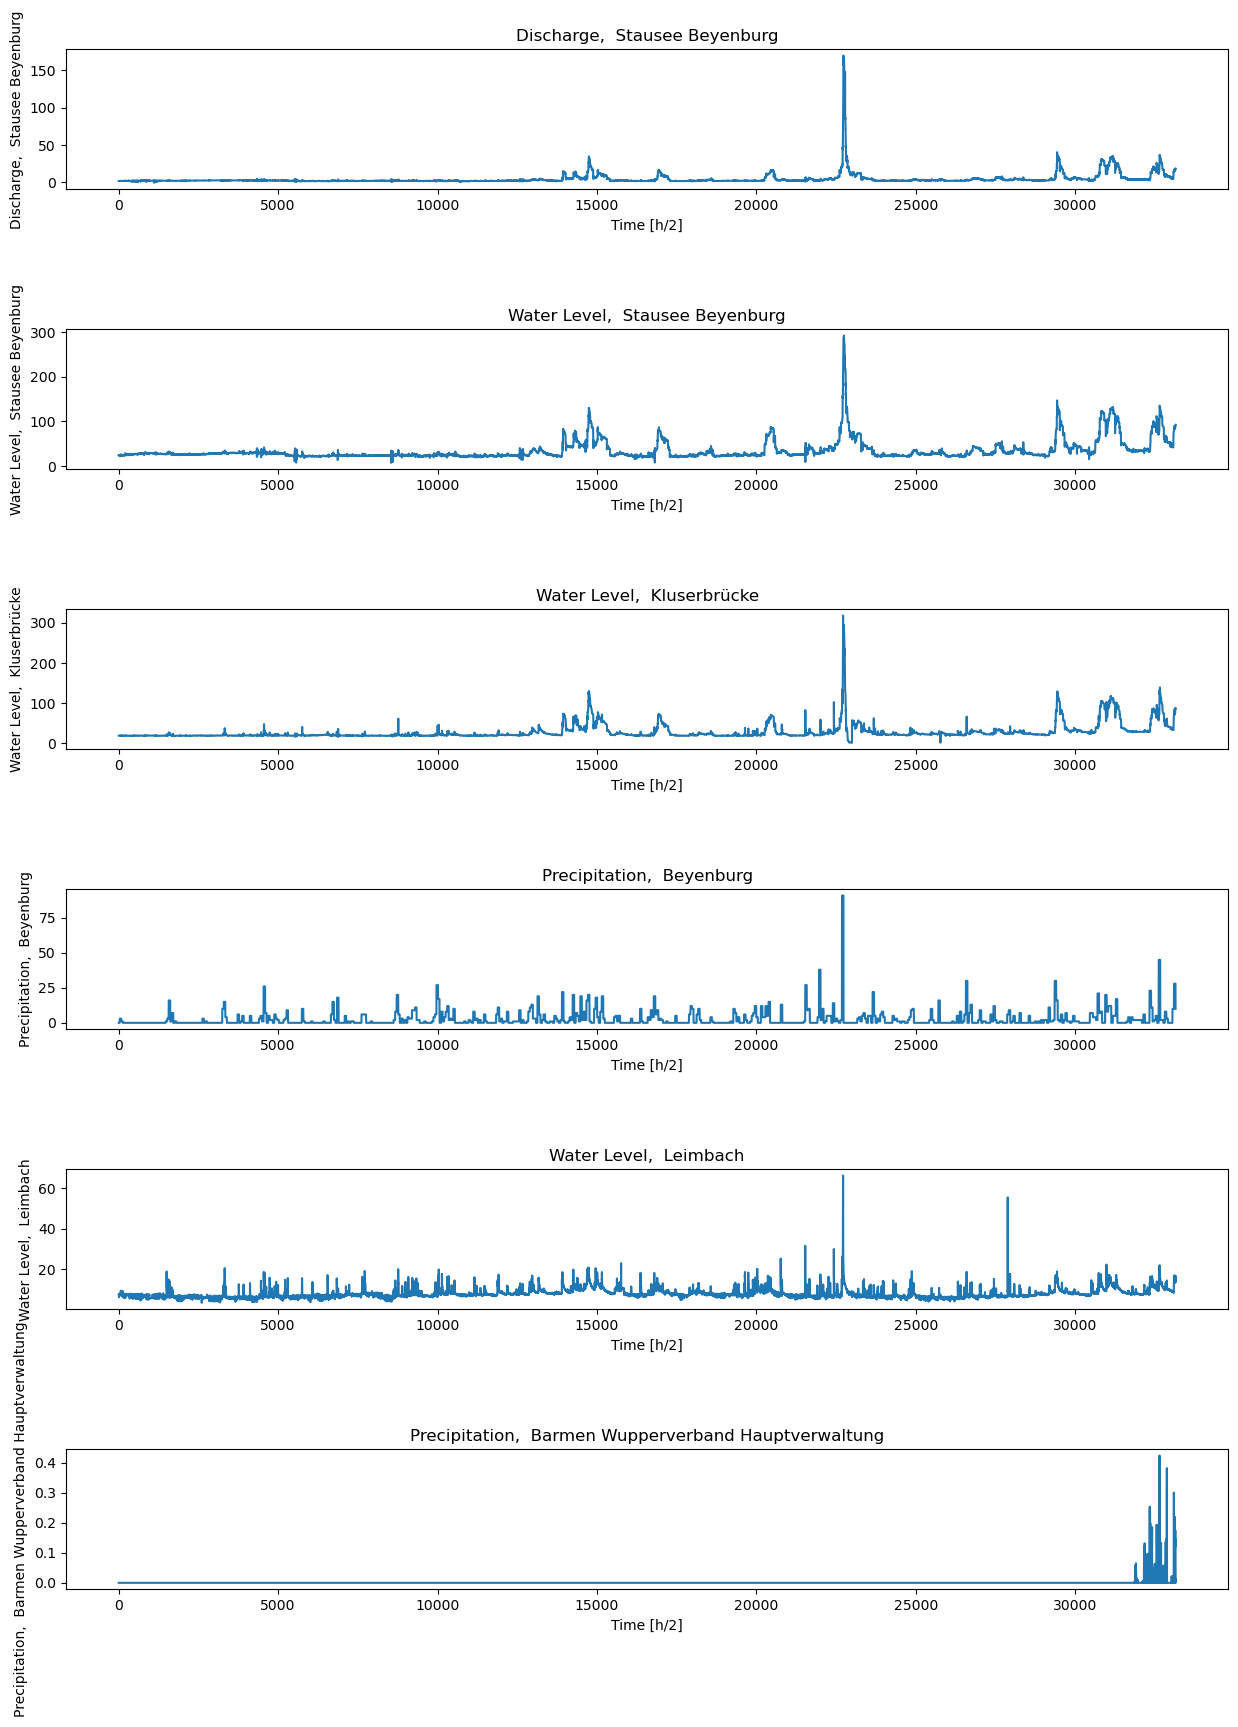

In [14]:
multi_singleplot(raw_data)

## The sample window
Create a window that shows 24 hours of observed data and the right dimensions to leave some space for the 6-hour prediction that is the task of this challenge. Ideally the function is flexible to be used easily on different intervals of our data.

In [15]:
def data_win(data: pd.DataFrame, start: int, column: int, pred=None):
    """
    Function that takes in a dataframe of sensor readings (data), an index (sorted by time) to start from and a column of the
    dataframe, given in as column number (0 to x). It returns a plot with 48 entries (24 hours)of observed data, 12 entries
    (6 hours) of observed that had to be predicted and, in case that own predictions were fed in, a visualization of the 12
    predictions entries.
    """

    windata = data.iloc[start:start + 48, column]
    labels = data.iloc[start + 48:start + 48 + 12, column]

    if pred is not None:
        plt.plot(np.arange(start + 48, start + 60, 1), pred, label='Prediction')

    plt.plot(np.arange(start, start + 48, 1), windata, label='Observed')
    plt.plot(np.arange(start + 48, start + 60, 1), labels, label='Target')

    plt.xlabel('Time [2/h)]')
    plt.ylabel(f'{data.keys()[column]}')
    plt.legend()

    plt.show()

In [16]:
# Just some random data as a placeholder for a real prediction
test_pred = np.random.rand(12) + 18.5

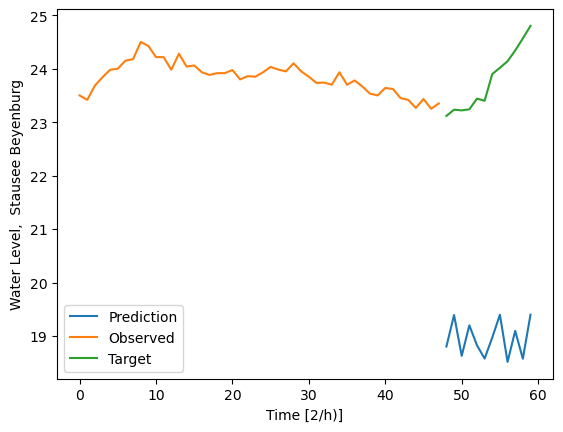

In [17]:
data_win(raw_data, 0, 1, pred=test_pred)

## Feature extraction
To predict the water level at the 'Kluserbrücke' measuring station, the simplest model would only try to predict future values by looking at previously measured water levels (the univariate case).

As there are other inputs available, like water levels at different measuring stations or precipitation measurements they could obviously be included in any model as well.

Besides these other directly available sensor inputs it could possibly be worthwhile to consider feature extraction/engineering in this case.

As an easy example one could use the time, shaped into a feature that especially depicts the periodic character of time (there is periodicity in time as we look at it day- or year-wise for example).

Example: Day-wise periodic feature:


In [18]:
# This function creates two day-wise periodic features (sin and cos) and adds those as columns to the dataframe.
# It also shows a little plot as demonstration.
# Expand the function to also accord for two year-wise periodic features

def periodizer(data: pd.DataFrame, date_format: str = 'day'):
    """
    Function to create a daily or yearly periodic feature out of a given dataset with a readable timestamp.
    date_format takes in a string (either 'day' or 'year') to define what feature has to be created.
    Output is an exemplary presentation of the periodic feature,
    with x-axis = time [h] and y-axis shows a sine or cosine signal.
    """

    per_dataset = data

    if date_format == 'day':
        per_data = per_dataset.index.hour
        # Day has 24 hours
        day = 24
        per_dataset['Day_sin'] = np.sin(per_data * 2 * np.pi/day)
        per_dataset['Day_cos'] = np.cos(per_data * 2 * np.pi/day)

        # Show a small example of how the signal looks
        plt.plot(np.array(per_dataset['Day_sin'])[0:200])
        plt.plot(np.array(per_dataset['Day_cos'])[0:200])

        plt.show()
        # return(per_dataset)

    elif date_format == 'year':
        per_data = per_dataset.index.day_of_year

        # Year has 365 days
        year = 365

        per_dataset['Year_sin'] = np.sin(per_data * 2 * np.pi/year)
        per_dataset['Year_cos'] = np.cos(per_data * 2 * np.pi/year)
        # Show a small example of how the signal looks
        plt.plot(np.array(per_dataset['Year_sin'])[0:20000])
        plt.plot(np.array(per_dataset['Year_cos'])[0:20000])

        plt.show()

    else:
        print("Incorrect date_format given in. Has to be either 'day' or 'year'.")
    return()

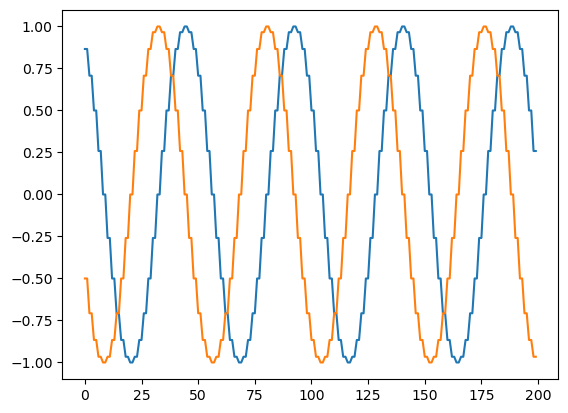

()

In [19]:
periodizer(raw_data, date_format='day')

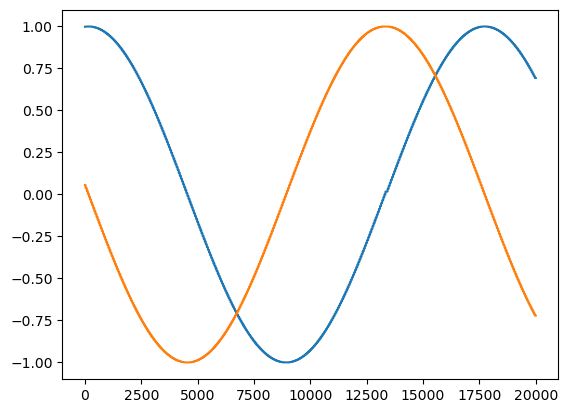

()

In [20]:
periodizer(raw_data, date_format='year')

Feel free to include all sensor readouts as features into your models and to think about features that could be created out of the available data (e.g. what sensors are up- or downstream to the target sensor and does this have an influence?)

If you consecutively include more and more features into your models, does the prediction quality improve? Could you even find a way to describe the usefulness of features to describe the final model quality?



## Load the Data into a Pytorch Dataset
In this example only one dimension of the input data is used. Multiple dimension might improve the results in the future.

A Pytorch is a standard class which is needed to be feed into every Pytorch Model
- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [21]:
data = raw_data["Water Level,  Kluserbrücke"].to_frame()
data.head()

,"Water Level, Kluserbrücke"
date,
2020-03-28 08:00:00,18.750000
2020-03-28 08:30:00,18.723077
2020-03-28 09:00:00,18.740000
2020-03-28 09:30:00,18.692857
2020-03-28 10:00:00,18.720000


## Scale the inputs so that

In [22]:
scaler = StandardScaler()
data[data.columns] = scaler.fit_transform(data[data.columns])
data.head()

,"Water Level, Kluserbrücke"
date,
2020-03-28 08:00:00,-0.465285
2020-03-28 08:30:00,-0.466618
2020-03-28 09:00:00,-0.465780
2020-03-28 09:30:00,-0.468113
2020-03-28 10:00:00,-0.466770


In [23]:
# split data intop two DataFrames: train train_kluse_water_level and validation val_kluse_water_level
# train 80% & validation 20%

train_kluse_water_level = data.iloc[:int(len(data) * 0.8)]
val_kluse_water_level = data.iloc[int(len(data) * 0.8):]

assert len(train_kluse_water_level) == 26522, "The train data size should be 26522"
assert len(val_kluse_water_level) == 6631, "The validation data size should be 6631"

## Create A Window Dataset
Full Data Sequence: $X = x_1, x_2, x_3, x_4, x_5, x_6, x_7$
- $window_1 = x_1, x_2, x_3$
- $window_2 = x_2, x_3, x_4$
- $window_3 = x_3, x_4, x_5$
- ...

In [24]:
class DataWindowDataset(Dataset):
    """
    This is a Pytorch Dataset. More Information can be found here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    The dataset returns the rolling window dataset with input x [x_1, .., x_48] and the target y [y_1, .., y_12]
    """
    def __init__(self, df: pd.DataFrame, input_size: int = 48, pred_size: int = 12):
        self.df = df
        self.window_len = input_size + pred_size
        self.pred_size = pred_size
        self.input_size = input_size

    def __len__(self) -> int:
        return len(self.df) - self.window_len

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        x = self.df.iloc[idx: idx + self.input_size].values
        y = self.df.iloc[idx + self.input_size: idx + self.window_len].values

        return torch.tensor(x, dtype=torch.float32).squeeze(), torch.tensor(y, dtype=torch.float32).squeeze()

In [25]:
train_ds = DataWindowDataset(df=train_kluse_water_level, input_size=48, pred_size=12)
val_ds = DataWindowDataset(df=val_kluse_water_level, input_size=48, pred_size=12)

In [26]:
idx = 0
idx_input = 0
idx_target = 1
print(f"len train dataset: {len(train_ds)} shape input: {train_ds[idx][idx_input].shape} shape target {train_ds[idx][idx_target].shape}")

len train dataset: 26462 shape input: torch.Size([48]) shape target torch.Size([12])


## Put Datasets into a Dataloader to get Batches

In [27]:
train_loader = DataLoader(train_ds, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_ds, shuffle=False, batch_size=batch_size)

## Define Model
In this case, we will define a simple MLP which can be used to forecast all 12-time steps at once. This NN has only one layer, which should not perform well. Feel free to experiment with different layers, add new layers and use different NN architectures to improve your results.

In [28]:
class MLP(nn.Module):
    def __init__(self, in_seq_len: int = 48, in_dim: int = 1, out_seq_len: int = 12, hidden_size: int = 64, dropout_p: float = 0.1):
        """
        This is a simple MLP which can be used as a starting point to predict a sequence. Different layers can be added in self.layers.
        @param in_seq_len: The input sequence length x_0, .., x_n  n = input sequence length
        @param in_dim: The input feature dimension
        @param out_seq_len: The output sequence length y_0, .., y_m  m = target sequence length
        @param hidden_size: The dimension of the hidden layers
        @param dropout_p: dropout probability if a dropout is used
        """
        super(MLP, self).__init__()
        self.hidden_size = hidden_size
        self.in_dim = in_dim

        self.layers = nn.Sequential(
            nn.Linear(in_seq_len * in_dim, hidden_size),
            nn.Linear(hidden_size, out_seq_len)
        )

    def forward(self, x: torch.tensor) -> Tensor:
        """
        This forward method is called by using model(x). It uses the input x to predict all time steps, so that the output
        should be the length od the target sequence
        @param x: input of the NN
        @return: output of the NN
        """
        batch_size = x.shape[0]
        if self.in_dim == 1:
            assert len(x.shape) == 2, f"if only one input feature is provided the input must have the input shape " \
                                      f"(batch_size, seq_len), but the shape is {x.shape}"
        else:
            assert len(x.shape) == 3 and self.in_dim == x.shape[2], f"if more than one input feature is provided the input must have " \
                                                                    f"the input shape (batch_size, seq_len, in_dim), but the shape is {x.shape}"

        return self.layers(x.reshape(batch_size, -1))



## Define Model and Loss Function

In [29]:
# init model
model = MLP(in_seq_len=48, out_seq_len=12, hidden_size=32).to(device)
print(model)

# Loss Function
mse_loss = nn.MSELoss()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=48, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=12, bias=True)
  )
)


## Train Loop

In [30]:
def train(model: MLP, train_loader: DataLoader, val_loader: DataLoader, learning_rate: float = 0.001,
          epochs: int = 6) -> MLP:
    """
    Train Loop
    @param model: The NN Model. The model must have the same forward return shape as the dataset has as target
    @param train_loader: Loader with training data
    @param val_loader: Loader with validation data
    @param learning_rate: Learning rate for the Adam optimizer
    @param epochs: number of training runs
    """

    # initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    size_train_loader = len(train_loader.dataset)
    for epoch_i in range(epochs):

        for batch_i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()

            # forward pass, compute predicted y

            pred = model(x)
            loss = mse_loss(pred, y)
            #

            # backpropagation part
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            optimizer.step()

            if batch_i % 50 == 0:
                loss, current = loss.item(), batch_i * batch_size
                print(f"{epoch_i:>2d} - [{current:>5d}/{size_train_loader:>5d}] MSE loss: {loss:>5f} ")

        # validate on data which was not used to train the model
        val_losses = []
        with torch.no_grad():
            for batch_i, (x, y) in enumerate(val_loader):
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_loss = mse_loss(pred, y)
                val_losses.append(val_loss.item())

        val_losses = np.mean(np.array(val_losses))
        print(
            "-" * 20 + "\n" +
            f"Val MSE Loss {val_losses} Val RMSE Loss {np.sqrt(val_losses)}\n" +
            "-" * 20 + "\n"
        )
    return model

model = train(model=model, train_loader=train_loader, val_loader=val_loader, epochs=10)

 0 - [    0/26462] MSE loss: 0.247123 
 0 - [ 1600/26462] MSE loss: 0.075959 
 0 - [ 3200/26462] MSE loss: 0.140509 
 0 - [ 4800/26462] MSE loss: 0.021530 
 0 - [ 6400/26462] MSE loss: 0.003079 
 0 - [ 8000/26462] MSE loss: 0.007969 
 0 - [ 9600/26462] MSE loss: 0.011906 
 0 - [11200/26462] MSE loss: 0.041207 
 0 - [12800/26462] MSE loss: 0.039916 
 0 - [14400/26462] MSE loss: 0.007292 
 0 - [16000/26462] MSE loss: 0.010689 
 0 - [17600/26462] MSE loss: 0.010356 
 0 - [19200/26462] MSE loss: 0.010151 
 0 - [20800/26462] MSE loss: 0.009275 
 0 - [22400/26462] MSE loss: 0.015692 
 0 - [24000/26462] MSE loss: 0.010869 
 0 - [25600/26462] MSE loss: 0.002304 
--------------------
Val MSE Loss 0.04994004203143455 Val RMSE Loss 0.22347268743950469
--------------------

 1 - [    0/26462] MSE loss: 0.009391 
 1 - [ 1600/26462] MSE loss: 0.010811 
 1 - [ 3200/26462] MSE loss: 0.064521 
 1 - [ 4800/26462] MSE loss: 0.012259 
 1 - [ 6400/26462] MSE loss: 0.007249 
 1 - [ 8000/26462] MSE loss: 0.0

# Test data
Now we need to load the unseen test data to make the prediction. Therefore, we will load the x_test file and convert it in the same way as before.

In [31]:
# load test data
test_data = pd.read_csv(f"{data_dir}/x_test.csv", sep=";", date_parser="date")
test_data = test_data["Water Level,  Kluserbrücke"].to_frame()
test_data[test_data.columns] = scaler.transform(test_data[test_data.columns])
test_data.head()

,"Water Level, Kluserbrücke"
0,2.888535
1,2.968545
2,3.135164
3,3.359522
4,3.610275


## Create a Test Pytorch Dataset
We need to create a new pytorch dataset because we do not have the unknown target values y.

In [32]:
class TestDataset(Dataset):
    def __init__(self, df: pd.DataFrame, input_size: int = 48, input_dim: int = 1,pred_size: int = 12):
        self.df = df
        self.window_len = input_size + pred_size
        self.pred_size = pred_size
        self.input_size = input_size
        self.input_dim = input_dim

    def __len__(self) -> int:
        return int(len(self.df) / self.input_size)

    def __getitem__(self, idx: int) -> Tensor:
        x = self.df.iloc[idx * self.input_size: (idx + 1) * self.input_size, :].values
        x =  torch.tensor(x, dtype=torch.float32)
        if self.input_dim == 1:
            x = x.reshape(-1)
        return x


test_ds = TestDataset(test_data)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=batch_size)

In [33]:
test_ds[0].shape

torch.Size([48])

## Test Loop
This function loops through the test data and saves the prediction in the test_value list so that the results can be uploaded to the challenge.

In [34]:
def test(model: nn.Module, test_loader: DataLoader) -> np.array:
    test_values = []
    with torch.no_grad():
        for batch_i, x in enumerate(test_loader):
            x = x.to(device)
            pred = model(x)
            test_value_batch = pred.cpu().detach().numpy()
            # loop over the batches to add the prediction to the test_values in the right order
            for test_prediction in test_value_batch:
                for test_value in test_prediction:
                    test_values.append(test_value)

    return np.array(test_values)


test_values = test(model=model, test_loader=test_loader)
assert len(
    test_values) == 1116, "The prediction must have the length 1116, otherwise values are missing or there are to many values"

## Scaler Inverse Scale the predicted values
We normalized the input values before. No we need to scale them back to have the right scaled prediction which can be compared to the real data points.

In [35]:
test_values = scaler.inverse_transform(test_values.reshape(1, -1)).reshape(-1)

### Load Sample file
The sample file can be loaded and used to replace the zero values.

In [36]:
y_test_data = pd.read_csv(f"{data_dir}/y_test.csv")
y_test_data.prediction = test_values
y_test_data.head()

,date,prediction
0,2022-02-18 00:30:00,115.339233
1,2022-02-18 01:00:00,115.073578
2,2022-02-18 01:30:00,114.216499
3,2022-02-18 02:00:00,113.939285
4,2022-02-18 02:30:00,114.564331


### Save to CSV file

In [37]:
y_test_data.to_csv(f"{data_dir}/solution.csv", index=False)

0


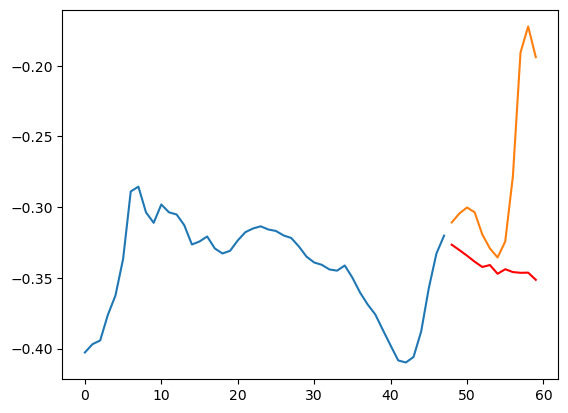

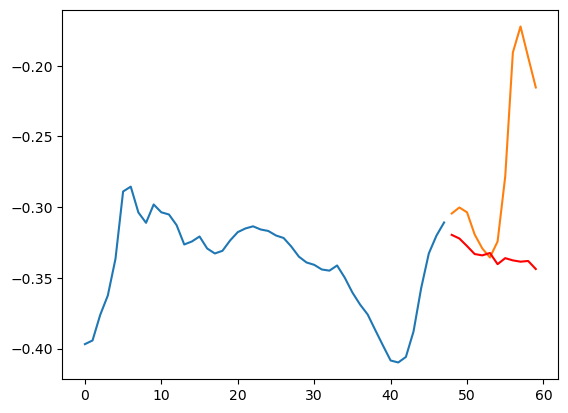

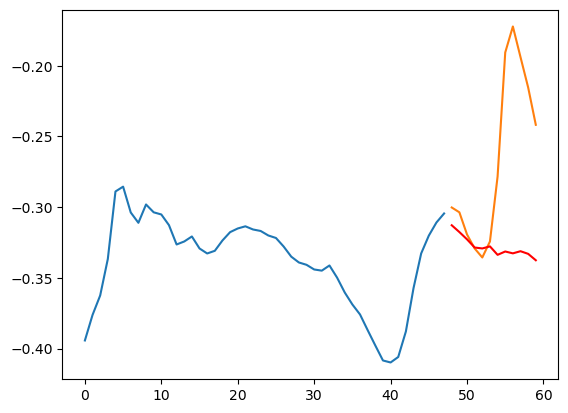

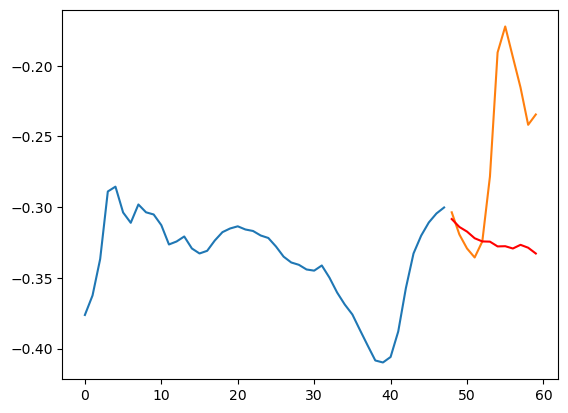

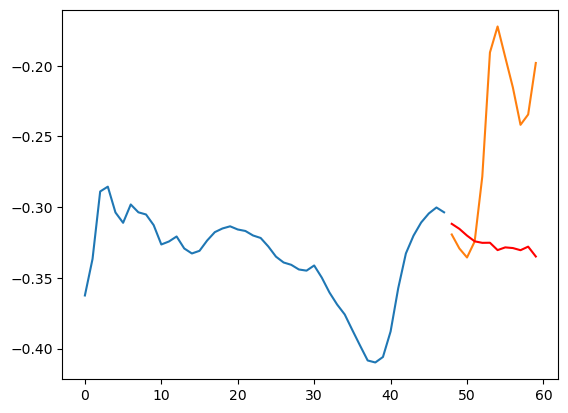

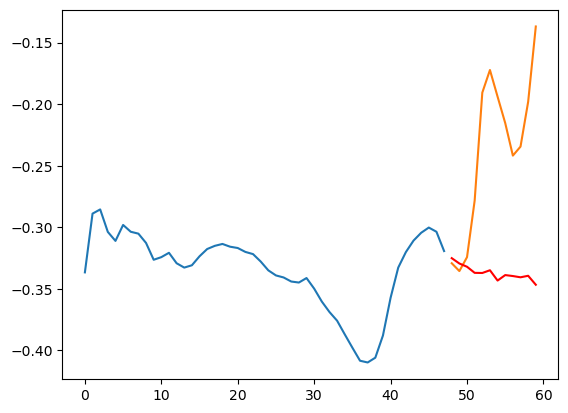

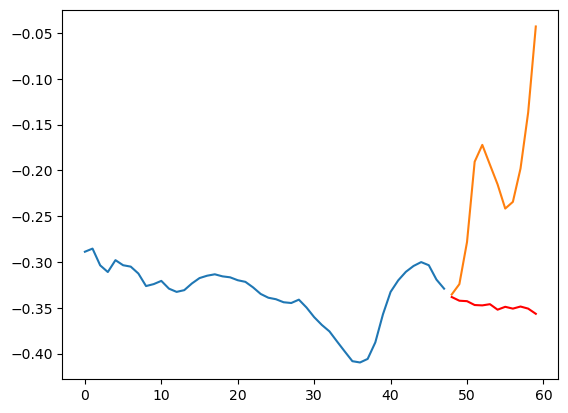

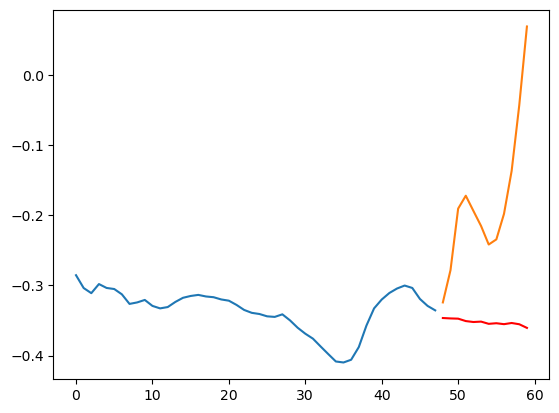

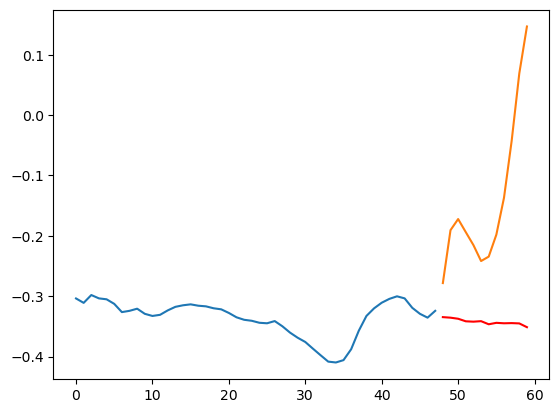

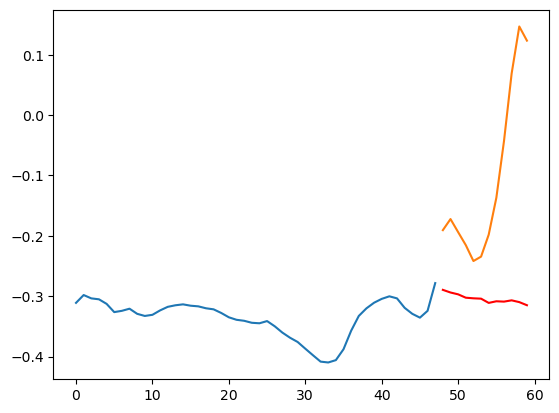

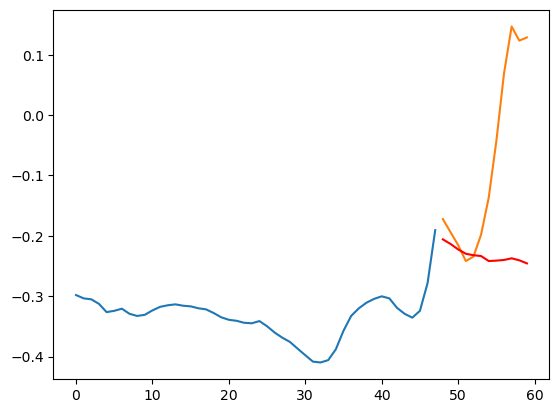

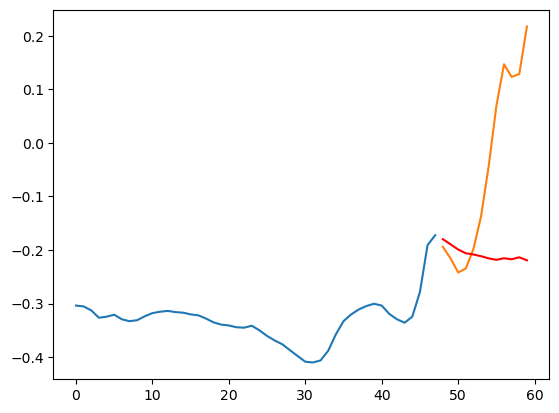

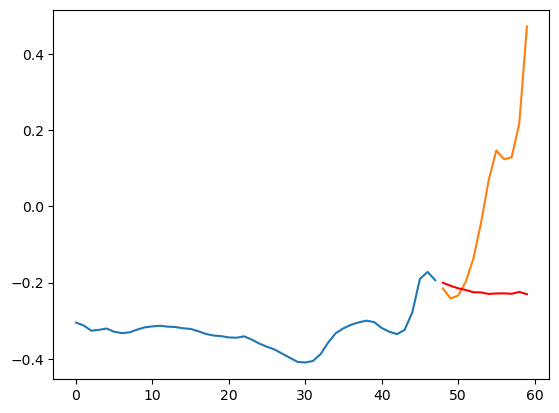

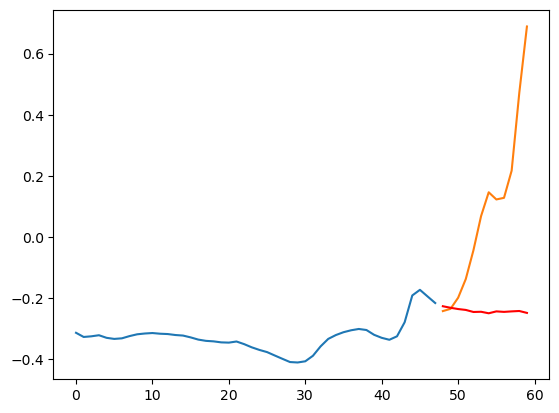

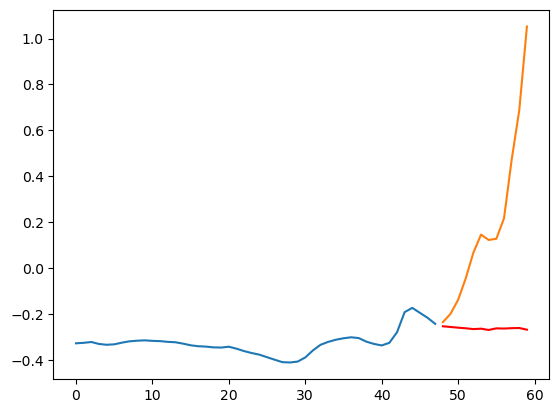

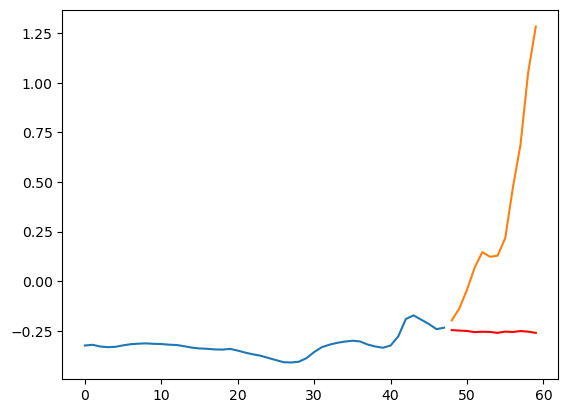

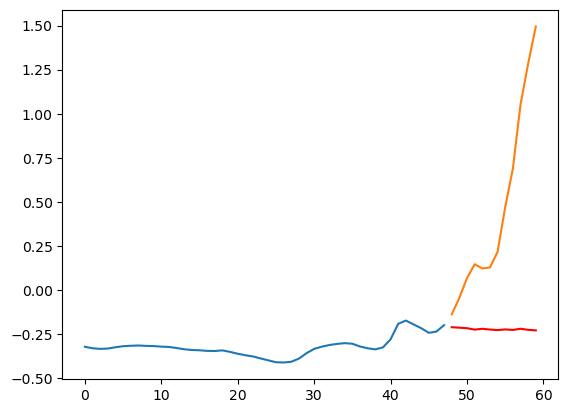

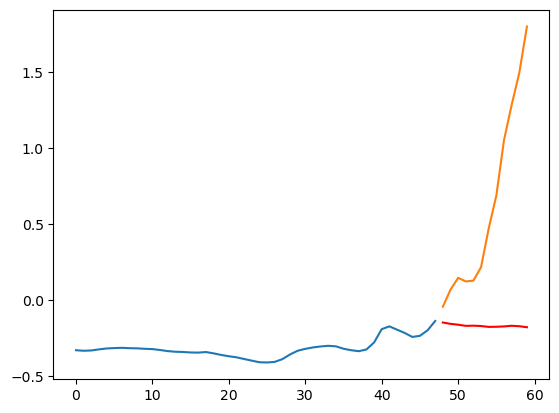

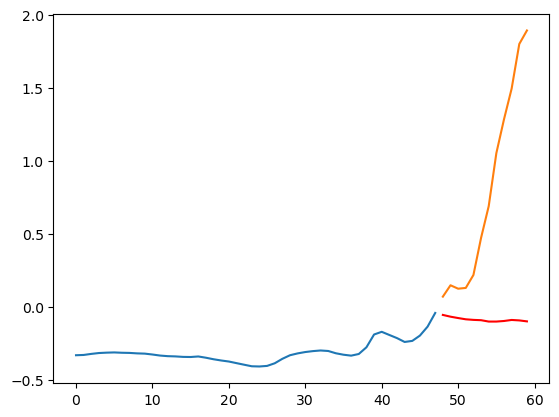

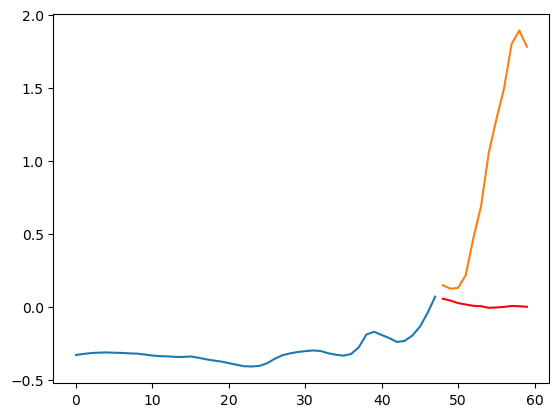

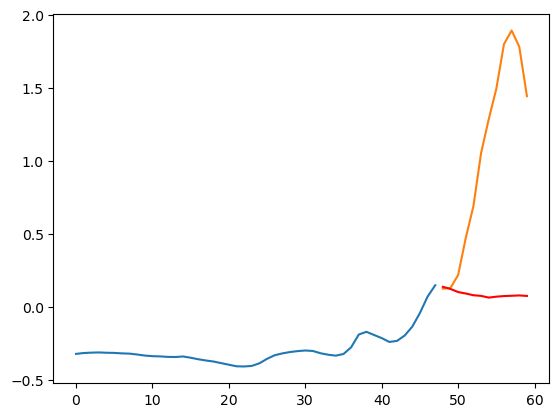

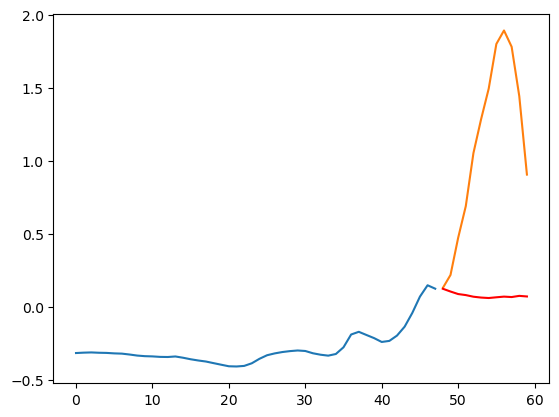

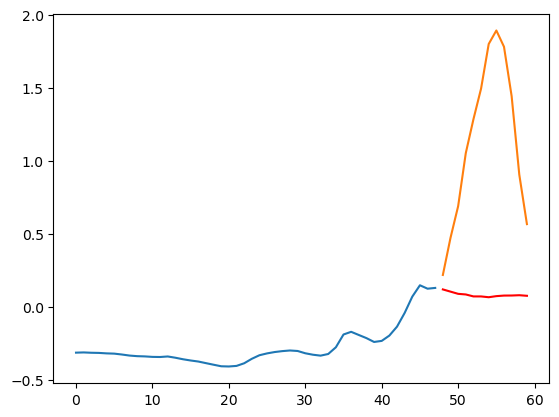

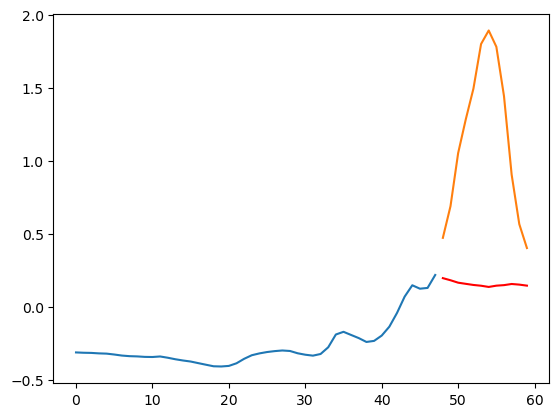

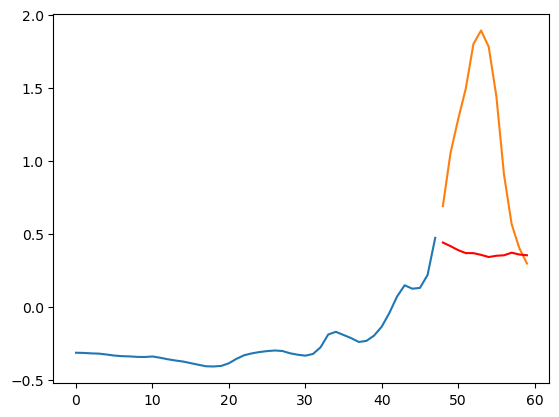

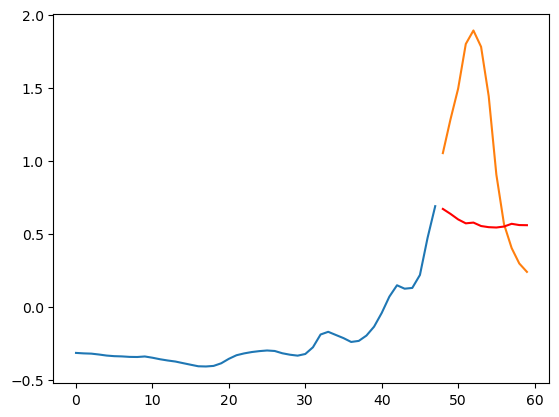

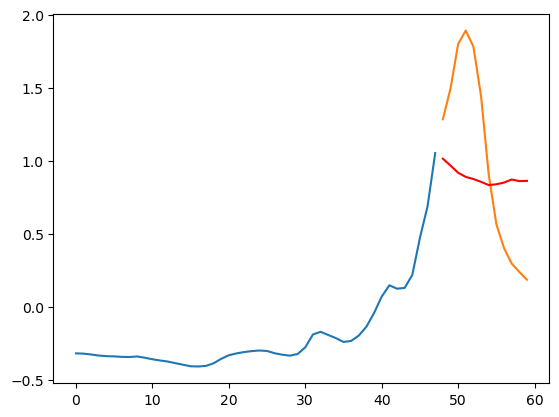

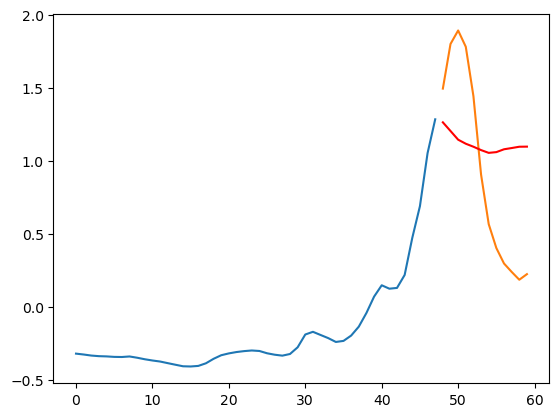

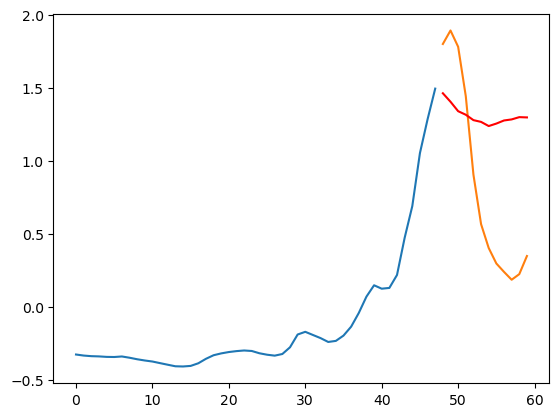

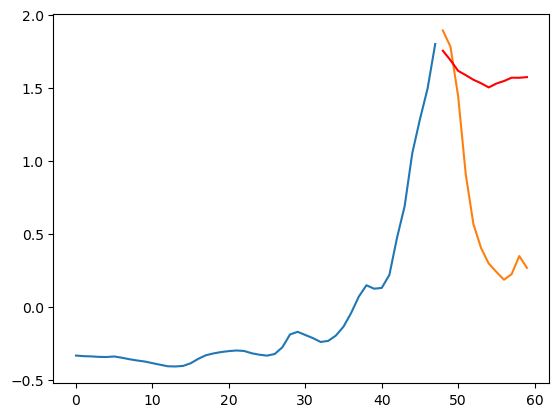

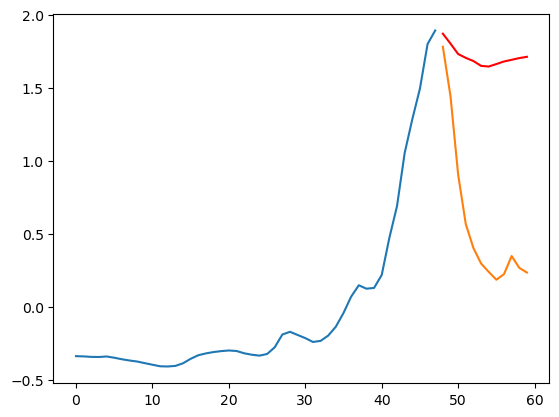

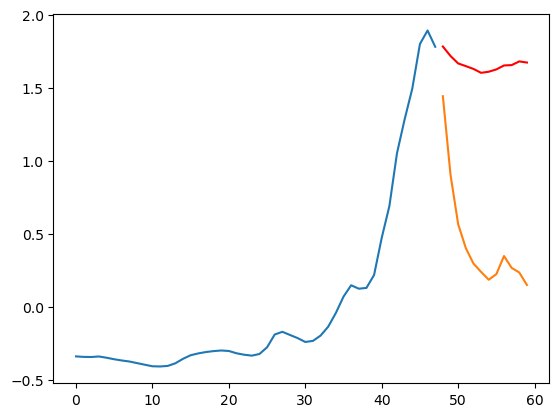

1


In [38]:
with torch.no_grad():
        for batch_i, (x, y) in enumerate(val_loader):
            print(batch_i)
            if batch_i == 1:
                break
            x, y = x.to(device), y.to(device)
            pred = model(x)
            val_loss = mse_loss(pred, y)
            for _x, _y, _pred in zip(x, y, pred):
                plt.plot(np.arange(0, 48, 1), _x)
                plt.plot(np.arange(48, 60, 1), _y)
                plt.plot(np.arange(48, 60, 1), _pred, color='red')
                plt.show()


## Submission
Now the predicted values (solution.csv) can be submitted on the website on the [Divabre Leaderboard](https://platform.divabre.de/challenges/c8d031ca-469e-4a3a-95fd-96ea7baeb687/leaderboard).

## Use Different Features as Input of the Neural Network
Now we can try out different features to improve the prediction. Additional data dimensions like the sensor 'Discharge,  Stausee Beyenburg' could be used as a feature. Or some temporal features like the day of the year. In this case, we will focus on the temporal feature. But feel free to try out your own ideas and experiment with the data.

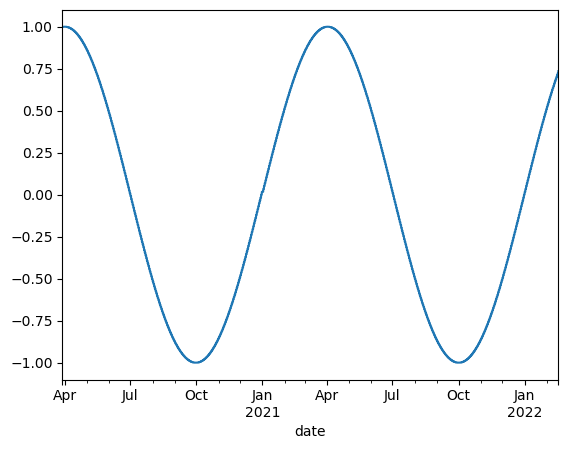

In [39]:
data = raw_data["Water Level,  Kluserbrücke"].to_frame()
# create a column 'year_sin' in the dataset with a sinus function over day of year

data['year_sin'] = np.sin(data.index.dayofyear * 2 * np.pi / 365)
assert 'year_sin' in data.columns and "Water Level,  Kluserbrücke" in data.columns, "data must include the columns year_sin and Water Level,  Kluserbrücke"
data['year_sin'].plot()
plt.show()

In [40]:
data = data[[ "year_sin", "Water Level,  Kluserbrücke"]]

## Scale Dataset

In [41]:
scaler = StandardScaler()
data[data.columns] = scaler.fit_transform(data[data.columns])
data.head()

,year_sin,"Water Level, Kluserbrücke"
date,,
2020-03-28 08:00:00,1.520109,-0.465285
2020-03-28 08:30:00,1.520109,-0.466618
2020-03-28 09:00:00,1.520109,-0.465780
2020-03-28 09:30:00,1.520109,-0.468113
2020-03-28 10:00:00,1.520109,-0.466770


In [42]:
# split train and validation set
#  -> train 80% & validation 20%

train_df = data.iloc[:int(len(data) * 0.8)]
val_df = data.iloc[int(len(data) * 0.8):]

In [43]:
class DataWindowDatasetFeatures(Dataset):
    def __init__(self, df: pd.DataFrame, input_size: int = 48, input_dim: int = 2, pred_size: int = 12):
        self.df = df
        self.window_len = input_size + pred_size
        self.pred_size = pred_size
        self.input_size = input_size
        self.input_dim = input_dim

    def __len__(self) -> int:
        return len(self.df) - self.window_len

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        x = self.df.iloc[idx: idx + self.input_size, :].values
        y = self.df.iloc[idx + self.input_size: idx + self.window_len, -1].values

        return torch.tensor(x, dtype=torch.float32).squeeze(), torch.tensor(y, dtype=torch.float32).squeeze()

In [44]:
# create train and validation dataset
train_ds = DataWindowDatasetFeatures(df=train_df, input_size=48, input_dim=2, pred_size=12)
val_ds = DataWindowDatasetFeatures(df=val_df, input_size=48, input_dim=2, pred_size=12)

assert train_ds[0][0].shape == torch.Size([48, 2]) and train_ds[0][1].shape == torch.Size([12]), \
    f"Error the shapes of the dataset must have torch.Size([48, 2]) and torch.Size([12], but are {train_ds[0][0].shape} and {train_ds[0][1].shape}"

In [45]:
train_loader = DataLoader(train_ds, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_ds, shuffle=False, batch_size=batch_size)

## Initialize MLP Model

In [46]:
# init MLP Model

model = MLP(in_seq_len=48, in_dim=2, out_seq_len=12, hidden_size=32).to(device)

In [47]:
# train the model

model = train(model, train_loader=train_loader, val_loader=val_loader)

 0 - [    0/26462] MSE loss: 0.347241 
 0 - [ 1600/26462] MSE loss: 0.021436 
 0 - [ 3200/26462] MSE loss: 0.005014 
 0 - [ 4800/26462] MSE loss: 0.006115 
 0 - [ 6400/26462] MSE loss: 0.019775 
 0 - [ 8000/26462] MSE loss: 0.013533 
 0 - [ 9600/26462] MSE loss: 0.127515 
 0 - [11200/26462] MSE loss: 0.482933 
 0 - [12800/26462] MSE loss: 0.007618 
 0 - [14400/26462] MSE loss: 0.028889 
 0 - [16000/26462] MSE loss: 0.010867 
 0 - [17600/26462] MSE loss: 0.015380 
 0 - [19200/26462] MSE loss: 0.013301 
 0 - [20800/26462] MSE loss: 0.055861 
 0 - [22400/26462] MSE loss: 0.021820 
 0 - [24000/26462] MSE loss: 0.075322 
 0 - [25600/26462] MSE loss: 0.048567 
--------------------
Val MSE Loss 0.0700393234843626 Val RMSE Loss 0.2646494350728197
--------------------

 1 - [    0/26462] MSE loss: 0.018138 
 1 - [ 1600/26462] MSE loss: 0.006961 
 1 - [ 3200/26462] MSE loss: 0.004718 
 1 - [ 4800/26462] MSE loss: 0.013770 
 1 - [ 6400/26462] MSE loss: 0.003558 
 1 - [ 8000/26462] MSE loss: 0.007

## Load the Test Data

In [48]:
# load test data

test_data = pd.read_csv(f"{data_dir}/x_test.csv", sep=";", date_parser="date")
test_data.date = pd.to_datetime(test_data.date)
test_data.index = test_data.date
test_data = test_data["Water Level,  Kluserbrücke"].to_frame()
test_data['year_sin'] = np.sin(test_data.index.dayofyear * 2 * np.pi / 365)

# scale the test data
test_data = test_data[["year_sin", "Water Level,  Kluserbrücke"]]
test_data[test_data.columns] = scaler.transform(test_data[test_data.columns])
test_data.head()

,year_sin,"Water Level, Kluserbrücke"
date,,
2022-02-17 00:30:00,1.139681,2.888535
2022-02-17 01:00:00,1.139681,2.968545
2022-02-17 01:30:00,1.139681,3.135164
2022-02-17 02:00:00,1.139681,3.359522
2022-02-17 02:30:00,1.139681,3.610275


## Create Test Dataset

In [49]:
test_ds = TestDataset(test_data, input_dim=2)
test_loader = DataLoader(test_ds, shuffle=False, batch_size=batch_size)

## Test

In [50]:
test_values = test(model=model, test_loader=test_loader)
assert len(
    test_values) == 1116, "The prediction must have the length 1116, otherwise values are missing or there are to many values"

In [51]:
# scale it back
scale_array = np.array([np.zeros(test_values.shape), test_values])
test_values = scaler.inverse_transform(scale_array.T)[:,1]

In [52]:
y_test_data = pd.read_csv(f"{data_dir}/y_test.csv")
y_test_data.prediction = test_values
y_test_data.head()

,date,prediction
0,2022-02-18 00:30:00,106.023823
1,2022-02-18 01:00:00,109.450585
2,2022-02-18 01:30:00,107.713806
3,2022-02-18 02:00:00,108.507460
4,2022-02-18 02:30:00,110.256369


In [53]:
y_test_data.to_csv(f"{data_dir}/solution_2.csv", index=False)

0


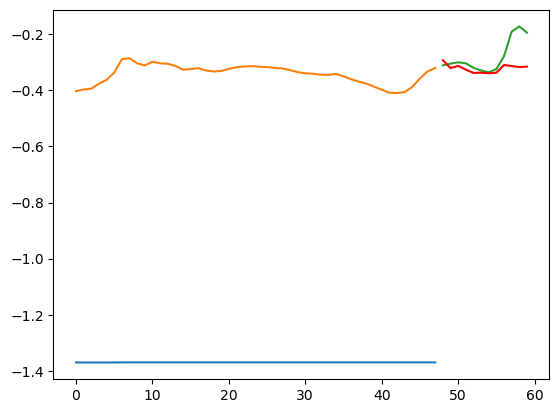

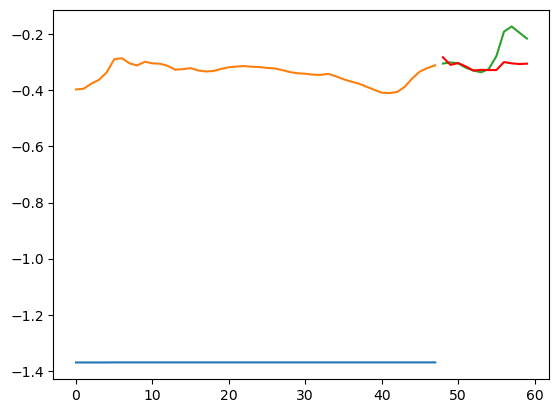

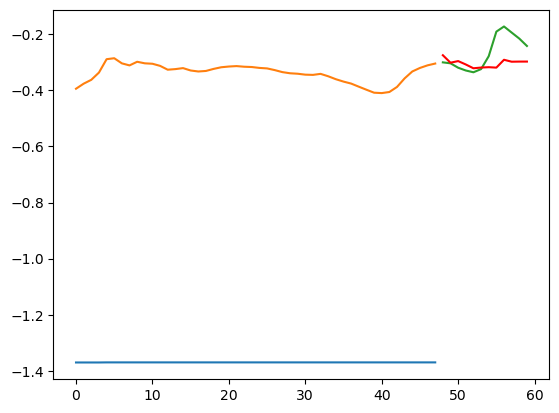

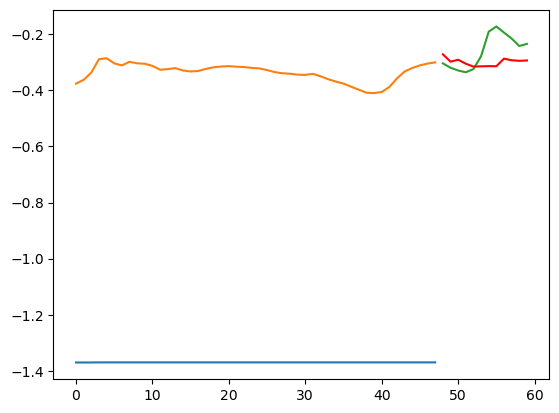

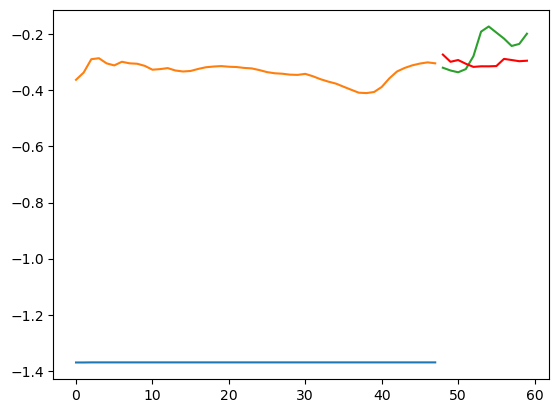

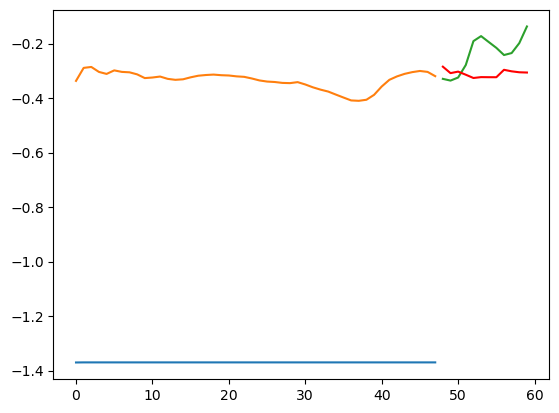

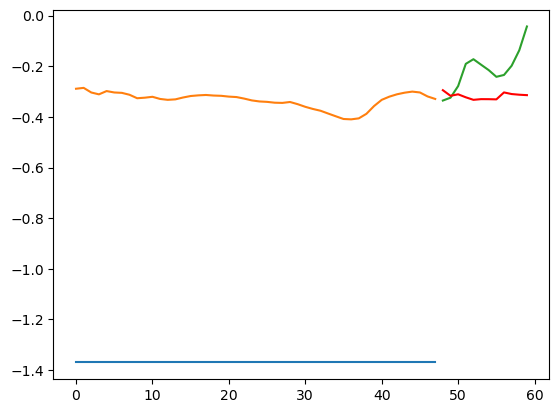

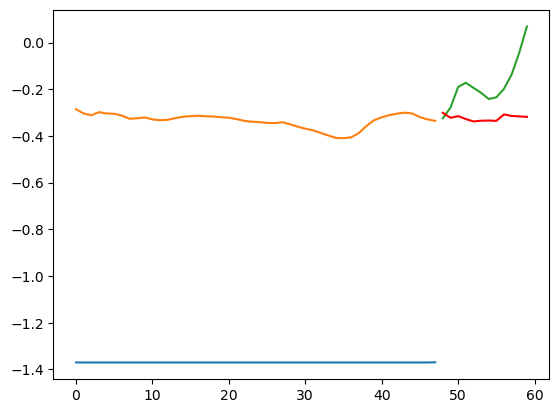

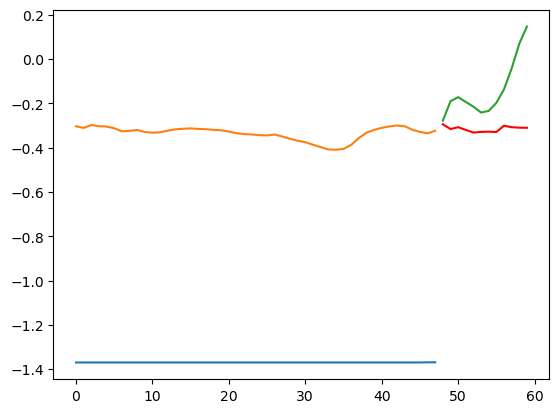

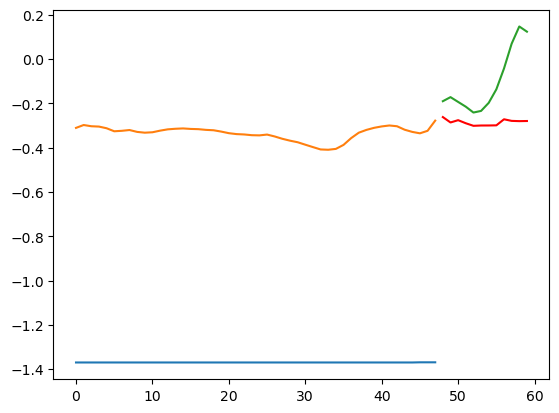

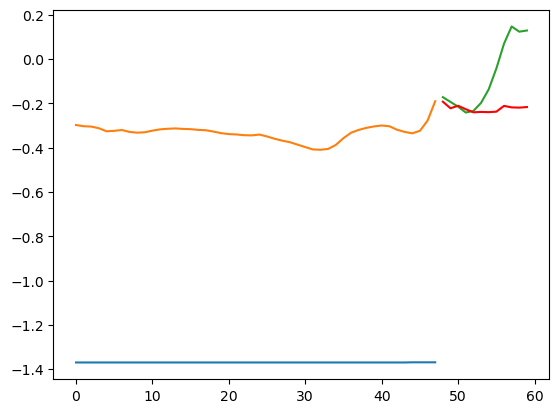

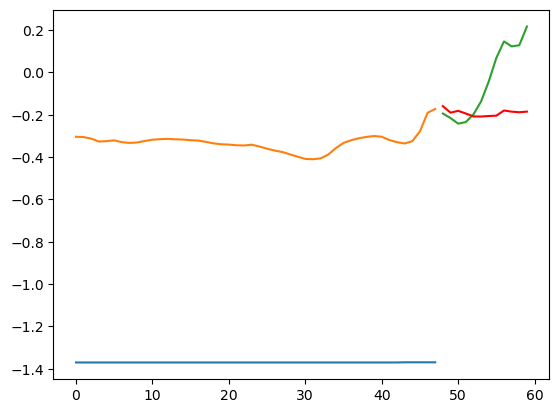

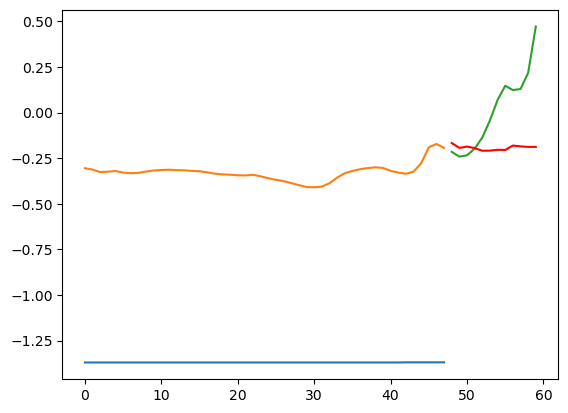

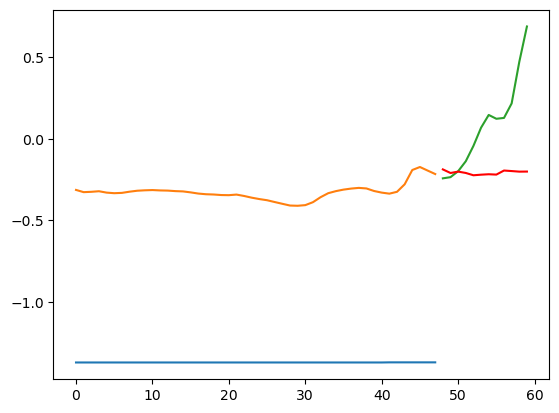

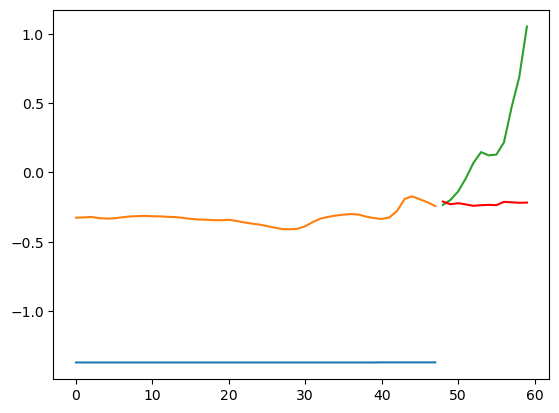

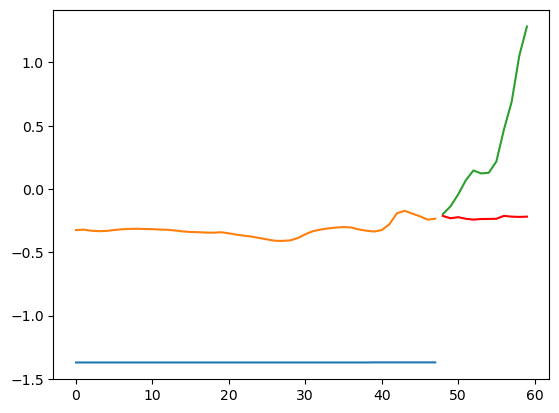

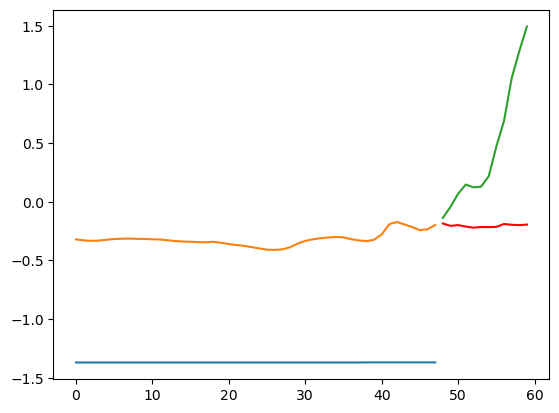

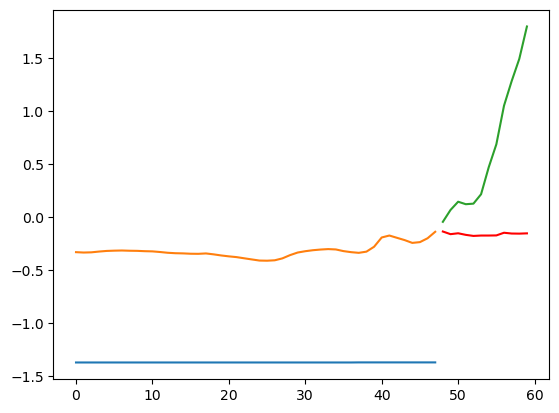

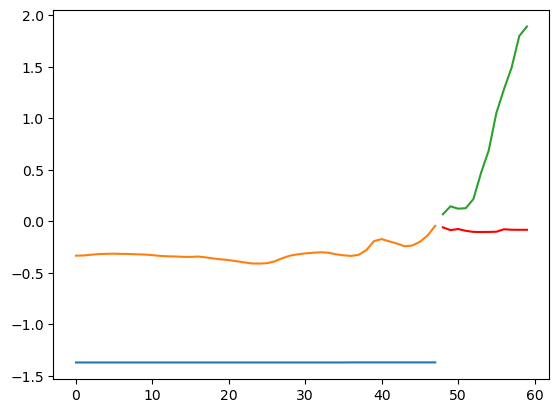

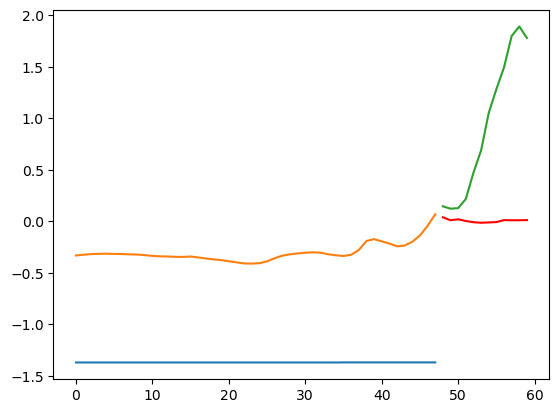

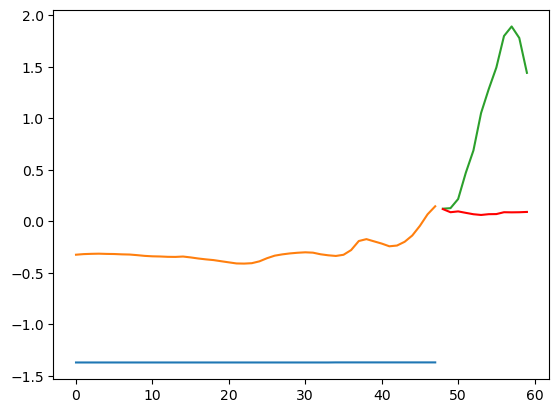

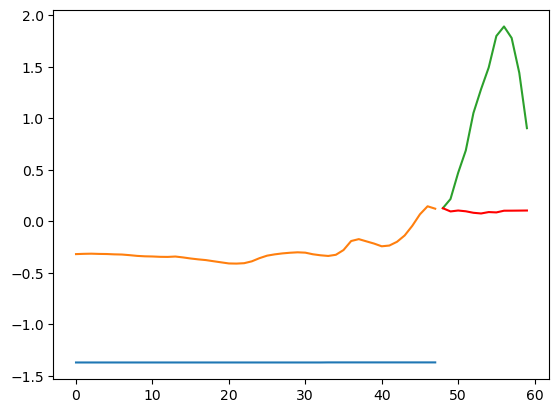

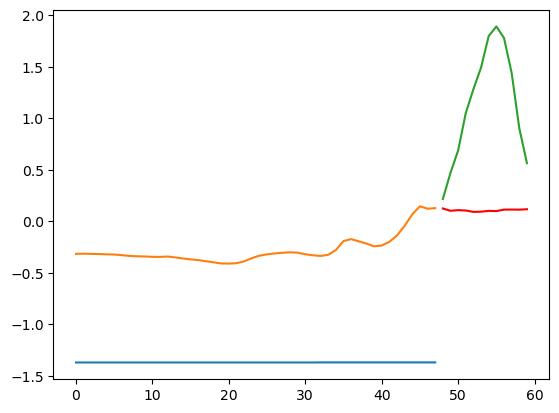

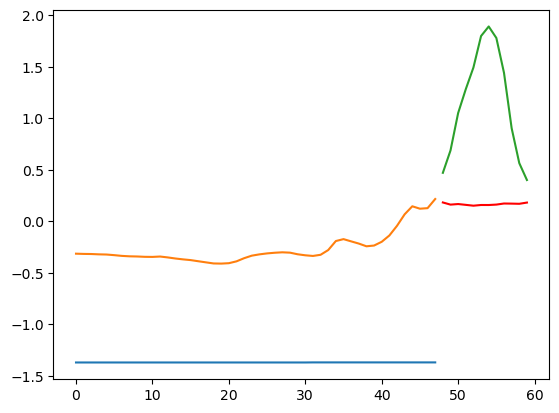

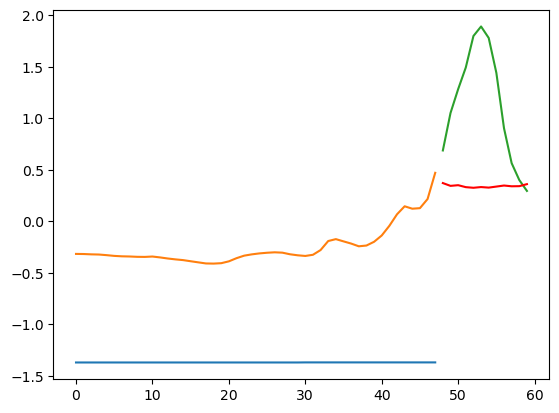

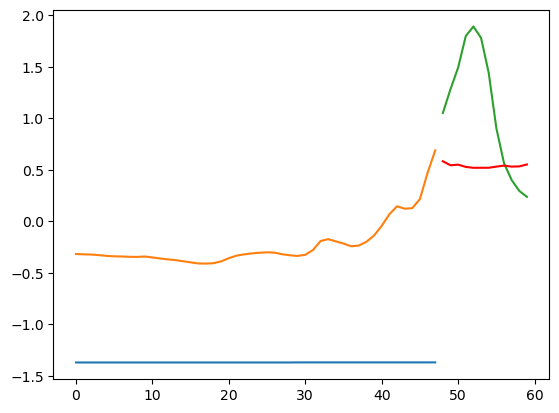

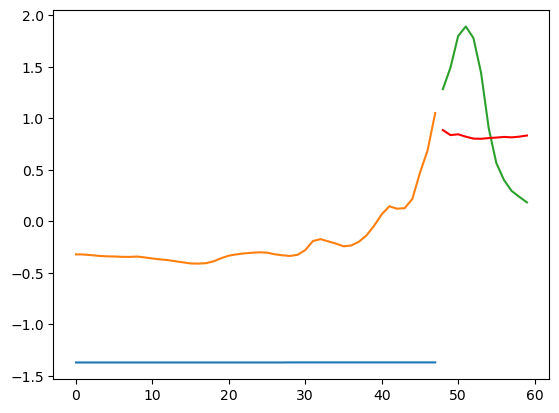

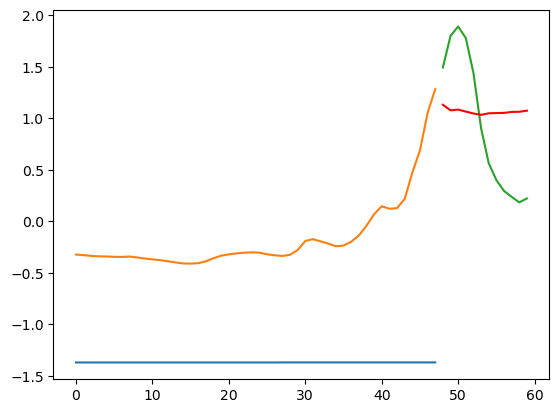

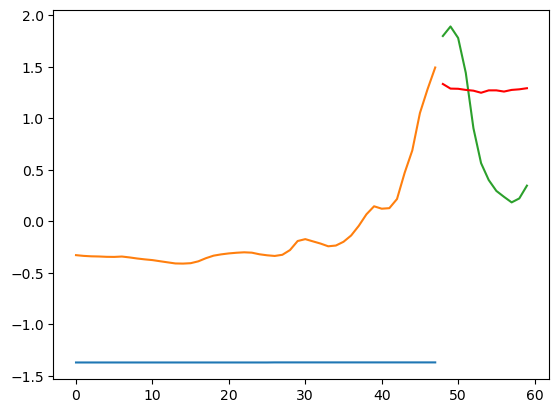

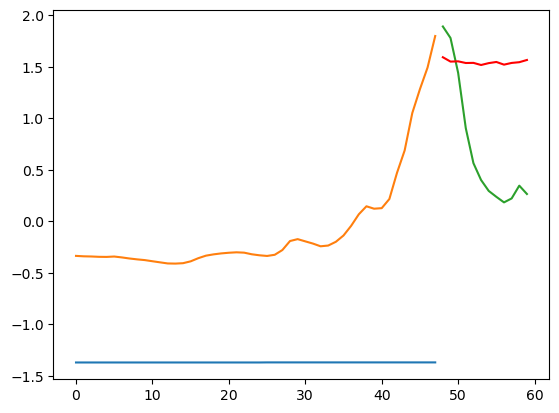

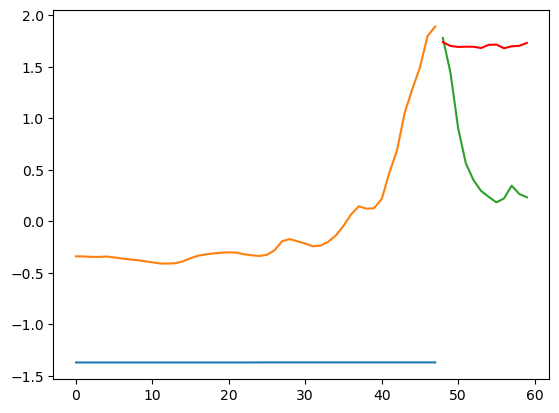

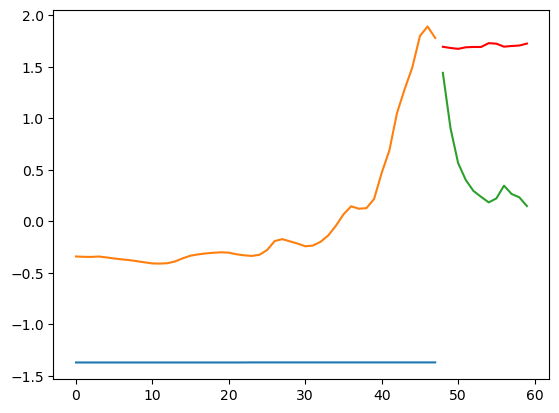

1


In [54]:
with torch.no_grad():
        for batch_i, (x, y) in enumerate(val_loader):
            print(batch_i)
            if batch_i == 1:
                break
            x, y = x.to(device), y.to(device)
            pred = model(x)
            val_loss = mse_loss(pred, y)
            for _x, _y, _pred in zip(x, y, pred):
                plt.plot(np.arange(0, 48, 1), _x)
                plt.plot(np.arange(48, 60, 1), _y)
                plt.plot(np.arange(48, 60, 1), _pred, color='red')
                plt.show()
  